# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [1]:
import psycopg2
import pandas as pd

In [2]:
tables = {'hr_dataset':None,'production_staff':None,
         'recruiting_costs':None,
         'salary_grid':None}

In [7]:
pg_connection = {
    'host': 'dsstudents.skillbox.ru',
    'port': '5432',
    'dbname': 'human_resources',
    'user': 'readonly',
    'password': '6hajV34RTQfmxhS'
}

In [9]:
hr_data=pd.read_sql_query("SELECT * FROM hr_dataset ",conn)
prod_staff=pd.read_sql_query("SELECT * FROM production_staff ",conn)
recr_costs=pd.read_sql_query("SELECT * FROM recruiting_costs ",conn)
sal_grid=pd.read_sql_query("SELECT * FROM salary_grid ",conn)

In [10]:
print(hr_data[['maritalstatusid','maritaldesc']])


     maritalstatusid maritaldesc
0                  1     Married
1                  2    Divorced
2                  0      Single
3                  1     Married
4                  0      Single
..               ...         ...
305                0      Single
306                0      Single
307                0      Single
308                1     Married
309                1     Married

[310 rows x 2 columns]


Зависимость perfomance score и тем, под чьим руководством работает сотрудник

In [11]:
pd.read_sql('''SELECT DISTINCT "Performance Score" 
                FROM production_staff
                WHERE "Performance Score" is not Null''',conn)

,Performance Score
0,Exceptional
1,90-day meets
2,N/A- too early to review
3,Fully Meets
4,Exceeds
5,PIP
6,Needs Improvement


In [14]:
pd.read_sql('''SELECT DISTINCT "Manager Name", 
/*
Составим полную таблицу
*/
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Exceptional') as "Exceptional", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = '90-day meets') as "90-day meets", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'N/A- too early to review') as "N/A- too early to review", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Fully Meets') as "Fully Meets", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Exceeds') as "Exceeds", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'PIP') as "PIP", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name" and 
                                B."Performance Score" = 'Needs Improvement') as "Needs Improvement", 
                (SELECT COUNT(B."Performance Score")
                                FROM production_staff B
                                WHERE B."Manager Name" = A."Manager Name") as "Sum"
                FROM production_staff A
                WHERE "Manager Name" is not Null''',
            conn)

,Manager Name,Exceptional,90-day meets,N/A- too early to review,Fully Meets,Exceeds,PIP,Needs Improvement,Sum
0,Amy Dunn,1,1,5,11,2,1,0,21
1,Brannon Miller,2,1,0,8,5,4,1,21
2,David Stanley,0,1,4,15,1,0,0,21
3,Elijiah Gray,0,3,3,14,2,0,1,23
4,Elisa Bramante,0,0,0,10,2,0,2,14
5,Kelley Spirea,0,3,1,15,3,0,0,22
6,Ketsia Liebig,0,2,2,14,2,0,1,21
7,Kissy Sullivan,1,3,1,14,1,1,1,22
8,Michael Albert,0,1,6,10,2,1,3,23
9,Webster Butler,0,3,3,11,2,0,2,21


У Brannon Miller больше всего сотрудников, качество работы которых превышает (Exceptional и Exceeds). У Michael Albert показатели сотрудников хуже всех (больше всех Needs Improvement, Fully Meets меньше всех, мало Exceeds и нет Exceptional). Отметим, что у него много сотрудников без оценок (N/A- too early to review).

Зависимость между продолжительностью работы в компании и семейным положением сотрудника

In [17]:
pd.read_sql(''' SELECT DISTINCT "maritaldesc" as Description,
/*
дальнейшие селекты работают по выбранному maritalstatusid (запрос с доп условием)
*/
                    (SELECT cast(avg(B."Days Employed") as int)
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Average", 
                    (SELECT cast(sum(B."Days Employed") as int)
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Sum", 
                    (SELECT count(B."Days Employed")
                    FROM hr_dataset B
                    WHERE B."maritalstatusid"=A."maritalstatusid") as "Number of workers"
                FROM hr_dataset A
                WHERE "maritalstatusid" is not Null''',conn) 

,description,Average,Sum,Number of workers
0,Divorced,1103,33086,30
1,Married,1246,153287,123
2,Separated,1703,20441,12
3,Single,1373,188067,137
4,Widowed,863,6904,8


Зависимость между способом найма к количеству сотрудников и их суммарной зп.

In [18]:
third_task = pd.read_sql(''' SELECT A."Employment Source", A."Total",

                (SELECT count(hr_dataset."Employee Source") 
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Number of current workers",
                (SELECT CAST(A."Total" as int) / NULLIF(count(hr_dataset."Employee Source"), 0)
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Cost of one employee",
                (SELECT cast(sum(salary_grid."Salary Mid") as int) / NULLIF((SELECT count(hr_dataset."Employee Source")
                                                                                FROM recruiting_costs B
                                                                                JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                                                                                WHERE B."Employment Source"=A."Employment Source" and
                                                                                hr_dataset."Employment Status"='Active'), 0)
                    FROM recruiting_costs B
                    JOIN hr_dataset on hr_dataset."Employee Source"=B."Employment Source"
                    JOIN salary_grid on salary_grid."Position"=hr_dataset."position"
                    WHERE B."Employment Source"=A."Employment Source" and
                    hr_dataset."Employment Status"='Active') as "Average salary of one worker"
                FROM recruiting_costs A''',conn)
third_task

,Employment Source,Total,Number of current workers,Cost of one employee,Average salary of one worker
0,Billboard,6192,11,562.0,29818.0
1,Careerbuilder,7790,1,7790.0,48000.0
2,Company Intranet - Partner,0,0,NaN,NaN
3,Diversity Job Fair,10021,9,1113.0,30746.0
4,Employee Referral,0,24,0.0,45362.0
5,Glassdoor,0,7,0.0,44450.0
6,Information Session,0,2,0.0,33425.0
7,Internet Search,0,4,0.0,22856.0
8,MBTA ads,10980,12,915.0,34666.0
9,Monster.com,5760,13,443.0,24834.0


Самым эффективным методом найма был Employee Referral 
Самым дорогим способом оказался поиск Careerbuilder, дальше Social Networks - Facebook Twitter
Выгодным оказался Newspager/Magazine

<ipython-input-21-6326a6a76e69>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  third_task.dropna()[third_task['Total'] != 0].plot(x='Cost of one employee',


<AxesSubplot:title={'center':'ЗП сотрудника к стоимости его найма'}, xlabel='Cost of one employee', ylabel='Average salary of one worker'>

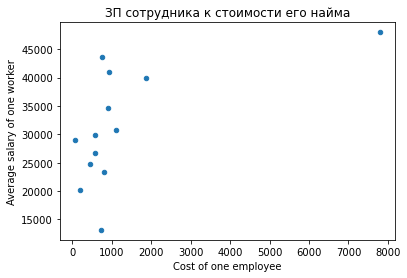

In [21]:
third_task.dropna()[third_task['Total'] != 0].plot(x='Cost of one employee', 
                                                   y='Average salary of one worker', 
                                                   kind='scatter',
                                                  title='ЗП сотрудника к стоимости его найма')

Идеальными способами поиска сотрудников будут те, чьи координаты в левом верхнем углу т.к. низкая стоимость за поиск одного сотрудника и высокая зп самого сотрудника (что говорит о его важности). 

## ЗАДАНИЕ 2


Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [57]:
import requests
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response
vk_token = '1629bde5200338034691ad3c02dfe9079b37f51e311d324fbc95d9b2bebc1bfa6cf168930031edb5c63f6'


In [58]:
from datetime import datetime, timedelta
k = -1
posts = list()
while True:
    k += 1
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + f'&owner_id=-66669811&offset={k}&count=1&v=5.92'
    response = getjson(url)
    try:
        it = response['response']["items"][0]
    except KeyError:
        k -= 1
        continue
    date = it['date']
    date = (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')
    it['date'] = date
    if date >= '2021-06-23':
        print(f"Progress {date}")
        continue
    elif date < '2021-01-01':
        break
    else:
        posts.append(it)
    print(f"Progress {date}")

Progress 2021-08-19 12:36:02
Progress 2021-09-13 19:00:55
Progress 2021-09-13 11:27:26
Progress 2021-09-12 10:59:31
Progress 2021-09-11 11:20:33
Progress 2021-09-09 17:02:31
Progress 2021-09-08 14:05:05
Progress 2021-09-08 13:54:37
Progress 2021-09-08 11:34:52
Progress 2021-09-07 12:50:52
Progress 2021-09-07 12:01:08
Progress 2021-09-06 19:31:14
Progress 2021-09-06 18:15:39
Progress 2021-09-06 17:52:53
Progress 2021-09-06 13:50:35
Progress 2021-09-04 11:34:51
Progress 2021-09-03 19:12:47
Progress 2021-09-03 12:48:12
Progress 2021-09-02 10:30:32
Progress 2021-09-01 19:04:37
Progress 2021-09-01 17:21:41
Progress 2021-08-31 18:55:31
Progress 2021-08-31 16:57:59
Progress 2021-08-31 15:26:39
Progress 2021-08-31 14:09:03
Progress 2021-08-30 13:33:47
Progress 2021-08-30 11:31:18
Progress 2021-08-28 12:00:32
Progress 2021-08-27 16:50:22
Progress 2021-08-27 15:13:14
Progress 2021-08-26 13:00:54
Progress 2021-08-26 12:08:48
Progress 2021-08-26 10:30:02
Progress 2021-08-25 15:26:22
Progress 2021-

Progress 2021-04-22 19:00:40
Progress 2021-04-22 17:30:02
Progress 2021-04-22 11:13:00
Progress 2021-04-21 18:30:02
Progress 2021-04-21 15:44:59
Progress 2021-04-21 12:29:09
Progress 2021-04-20 19:48:03
Progress 2021-04-20 18:30:17
Progress 2021-04-20 13:34:22
Progress 2021-04-19 17:58:47
Progress 2021-04-19 14:00:47
Progress 2021-04-19 11:08:16
Progress 2021-04-18 14:45:17
Progress 2021-04-18 13:32:15
Progress 2021-04-17 17:00:12
Progress 2021-04-17 16:59:53
Progress 2021-04-17 16:59:26
Progress 2021-04-17 10:19:41
Progress 2021-04-16 18:13:35
Progress 2021-04-16 12:44:26
Progress 2021-04-15 19:53:22
Progress 2021-04-15 18:15:09
Progress 2021-04-14 19:46:57
Progress 2021-04-14 15:45:04
Progress 2021-04-14 11:28:07
Progress 2021-04-13 20:25:07
Progress 2021-04-13 17:01:01
Progress 2021-04-13 15:09:23
Progress 2021-04-12 19:01:27
Progress 2021-04-12 14:57:56
Progress 2021-04-12 12:02:32
Progress 2021-04-11 11:38:24
Progress 2021-04-10 13:29:05
Progress 2021-04-09 19:15:19
Progress 2021-

In [59]:
d_posts = {i:posts[i] for i in range(len(posts))}


In [60]:
import json
with open("posts.json", "w") as f:
    json.dump(d_posts, f)

In [61]:
posts = None
with open("posts.json",'r') as f:
    posts = json.load(f)

In [62]:
posts = list(posts.values())


In [63]:
posts[0]

{'id': 184068,
 'from_id': -66669811,
 'owner_id': -66669811,
 'date': '2021-06-22 18:19:33',
 'marked_as_ads': 0,
 'post_type': 'post',
 'text': 'В помощь геймдизайнеру:\n\n— Как придумать идею\n— Чем урбанистика поможет геймдизайнеру\n— Как сделать командную работу эффективной\n— Как создание игры помогает справиться с личной трагедией\n— В чём преимущества видеоигр перед реальной жизнью\n\nЧитайте нашу подборку, смотрите классные выступления!\n\n#skillbox_игры #статья_skillbox',
 'attachments': [{'type': 'link',
   'link': {'url': 'https://m.vk.com/@skillbox-5-vystuplenii-c-ted-poleznyh-dlya-geimdizainerov',
    'title': '5 выступлений c TED, полезных для геймдизайнеров',
    'caption': 'm.vk.com',
    'description': 'Статья',
    'photo': {'album_id': -66,
     'date': 1624374957,
     'id': 457524151,
     'owner_id': -66669811,
     'has_tags': False,
     'sizes': [{'height': 45,
       'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.j

In [64]:
posts[0].keys()

dict_keys(['id', 'from_id', 'owner_id', 'date', 'marked_as_ads', 'post_type', 'text', 'attachments', 'post_source', 'comments', 'likes', 'reposts', 'views', 'is_favorite', 'hash'])

In [65]:
# Выделяем признаки
# Дата публикации
# Текст публикации
# Комментарии
# Лайки
# Репосты
# Просмотры
# тип поста

In [66]:
att_types = {}
for p in posts:
    for a in p['attachments']:
        if not a['type'] in att_types:
            att_types[a['type']] = a

In [67]:
att_types.keys()


dict_keys(['link', 'photo', 'video', 'poll', 'album', 'doc'])

In [68]:
for key, val in att_types.items():
    print('\n', key, '\n')
    for k, v in val[key].items():
        print(f'{k}:{v}')


 link 

url:https://m.vk.com/@skillbox-5-vystuplenii-c-ted-poleznyh-dlya-geimdizainerov
title:5 выступлений c TED, полезных для геймдизайнеров
caption:m.vk.com
description:Статья
photo:{'album_id': -66, 'date': 1624374957, 'id': 457524151, 'owner_id': -66669811, 'has_tags': False, 'sizes': [{'height': 45, 'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.jpg?size=130x44&quality=96&sign=7cb1eb353ced6beb7e9017f830dc69dc&c_uniq_tag=mVPdM8O8Y938fxQ4ZjfEAplKQx0VL4IqQcHnVVMmJdw&type=album', 'type': 'm', 'width': 130}, {'height': 87, 'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.jpg?size=130x87&quality=96&crop=572,0,1195,800&sign=b46524ef63c2dbae277444049beef383&c_uniq_tag=Fmj6_IKdFI0o-VUm0BOgW-PcYJ4Jl6LYmcQ7xLZA7wU&type=album', 'type': 'o', 'width': 130}, {'height': 133, 'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.jpg?size=200x133&quality=96&crop=568,0,1203

In [69]:
import re # для хештегов
temp = re.compile(r"#[\wА-Яа-яЁё_]+")


In [70]:
df = dict.fromkeys(['id', 'date', 'time', 'text_len',
                    'attachments_num', 'hashtag','view',
                    'comment', 'like','repost',
                    'poll_votes', 'poll_answers'])
for i in df:
    df[i] = list()

In [71]:
posts[0]


{'id': 184068,
 'from_id': -66669811,
 'owner_id': -66669811,
 'date': '2021-06-22 18:19:33',
 'marked_as_ads': 0,
 'post_type': 'post',
 'text': 'В помощь геймдизайнеру:\n\n— Как придумать идею\n— Чем урбанистика поможет геймдизайнеру\n— Как сделать командную работу эффективной\n— Как создание игры помогает справиться с личной трагедией\n— В чём преимущества видеоигр перед реальной жизнью\n\nЧитайте нашу подборку, смотрите классные выступления!\n\n#skillbox_игры #статья_skillbox',
 'attachments': [{'type': 'link',
   'link': {'url': 'https://m.vk.com/@skillbox-5-vystuplenii-c-ted-poleznyh-dlya-geimdizainerov',
    'title': '5 выступлений c TED, полезных для геймдизайнеров',
    'caption': 'm.vk.com',
    'description': 'Статья',
    'photo': {'album_id': -66,
     'date': 1624374957,
     'id': 457524151,
     'owner_id': -66669811,
     'has_tags': False,
     'sizes': [{'height': 45,
       'url': 'https://sun1-19.userapi.com/impg/sQou_niF_eNxOLoNyL2G0bbVnrB0Zh_2miUFyw/uqjwr31Fobo.j

In [72]:
for i, el in enumerate(posts):
    id_ = i
    date, time = el["date"].split()
    text = el["text"]
    text_len = len(text)
    hashtags = temp.findall(text)
    view = el["views"]["count"]
    comment = el["comments"]["count"]
    like = el["likes"]["count"]
    repost = el["reposts"]["count"]
    attachments = el["attachments"]
    attachments_num = len(attachments)
    poll_votes = 0
    poll_answers = 0
    for a in attachments:
        if a["type"] == "poll":
            answers = a["poll"]["answers"]
            poll_answers = len(answers)
            for an in answers:
                poll_votes += an["votes"]
    for h in hashtags:
        df["id"].append(id_)
        df["date"].append(date)
        df["time"].append(time)
        df["text_len"].append(text_len)
        df["hashtag"].append(h[1:])
        df["view"].append(view)
        df["comment"].append(comment)
        df["like"].append(like)
        df["repost"].append(repost)
        df["attachments_num"].append(attachments_num)
        df["poll_votes"].append(poll_votes)
        df["poll_answers"].append(poll_answers)

In [73]:
df

{'id': [0,
  0,
  1,
  2,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  11,
  12,
  12,
  13,
  14,
  15,
  16,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  35,
  36,
  36,
  37,
  38,
  38,
  39,
  40,
  40,
  41,
  42,
  42,
  43,
  45,
  46,
  47,
  48,
  48,
  49,
  49,
  50,
  51,
  52,
  52,
  53,
  54,
  54,
  55,
  56,
  57,
  57,
  58,
  60,
  60,
  62,
  63,
  64,
  65,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  79,
  80,
  80,
  81,
  82,
  83,
  84,
  84,
  85,
  85,
  86,
  87,
  88,
  89,
  89,
  90,
  90,
  91,
  92,
  93,
  94,
  94,
  95,
  96,
  96,
  97,
  98,
  99,
  100,
  100,
  101,
  101,
  103,
  104,
  104,
  105,
  106,
  106,
  107,
  108,
  109,
  110,
  110,
  111,
  112,
  113,
  114,
  114,
  115,
  115,
  116,
  117,
  118,
  118,
  119,
  120,
  121,
  122,
  122,
  123,
  124,
  125,
  129,
  129,
  130,
  1

In [74]:
df = pd.DataFrame(df)
df.head()

,id,date,time,text_len,attachments_num,hashtag,view,comment,like,repost,poll_votes,poll_answers
0,0,2021-06-22,18:19:33,327,1,skillbox_игры,16529,0,50,52,0,0
1,0,2021-06-22,18:19:33,327,1,статья_skillbox,16529,0,50,52,0,0
2,1,2021-06-22,13:30:46,658,5,skillbox_курсы,16708,4,37,14,0,0
3,2,2021-06-21,18:43:52,110,1,skillbox_маркетинг,19354,6,52,49,0,0
4,2,2021-06-21,18:43:52,110,1,статья_skillbox,19354,6,52,49,0,0


,id,date,time,text_len,attachments_num,hashtag,view,comment,like,repost,poll_votes,poll_answers
0,0,2021-06-22,18:19:33,327,1,skillbox_игры,16529,0.00,3.02,3.15,0.0,0
1,0,2021-06-22,18:19:33,327,1,статья_skillbox,16529,0.00,3.02,3.15,0.0,0
2,1,2021-06-22,13:30:46,658,5,skillbox_курсы,16708,0.24,2.21,0.84,0.0,0
3,2,2021-06-21,18:43:52,110,1,skillbox_маркетинг,19354,0.31,2.69,2.53,0.0,0
4,2,2021-06-21,18:43:52,110,1,статья_skillbox,19354,0.31,2.69,2.53,0.0,0


In [81]:
del df_no_hash['index']
del df_no_hash['id']
df_no_hash.head()

,date,time,text_len,attachments_num,view,comment,like,repost,poll_votes,poll_answers
0,2021-01-02,13:49:22,253,6,48289,191.867517,93.901813,96.108236,0.0,0
1,2021-01-04,17:00:23,353,1,36148,785.235578,96.584722,94.506432,0.0,0
2,2021-01-06,19:46:29,614,1,34151,21.318613,42.255816,31.502144,0.0,0
3,2021-01-08,19:44:11,548,1,30519,117.252371,54.999633,38.443294,0.0,0
4,2021-01-08,17:00:18,146,1,28224,0.000000,84.511631,90.768889,0.0,0


In [82]:
# смотрим матрицу корреляций

In [83]:
import seaborn as sns
corr_m = df.loc[:, 'text_len':].corr()
corr_m

,text_len,attachments_num,view,comment,like,repost,poll_votes,poll_answers
text_len,1.000000,0.061010,-0.015412,-0.016005,-0.122461,-0.180230,0.091202,0.098069
attachments_num,0.061010,1.000000,0.281626,0.046852,0.493966,0.322564,-0.055365,-0.060204
view,-0.015412,0.281626,1.000000,0.136601,0.308116,0.234248,0.142202,0.086336
comment,-0.016005,0.046852,0.136601,1.000000,0.110150,0.056914,0.234605,0.195083
like,-0.122461,0.493966,0.308116,0.110150,1.000000,0.730428,-0.019207,-0.051782
repost,-0.180230,0.322564,0.234248,0.056914,0.730428,1.000000,-0.061648,-0.079753
poll_votes,0.091202,-0.055365,0.142202,0.234605,-0.019207,-0.061648,1.000000,0.844494
poll_answers,0.098069,-0.060204,0.086336,0.195083,-0.051782,-0.079753,0.844494,1.000000


<AxesSubplot:>

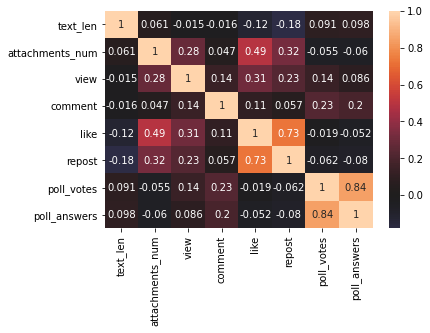

In [84]:
sns.heatmap(corr_m, center=0, annot=True)

* длина текста имеет слабо выраженную корреляцию
* доля просмотров хорошо выражена между лайками и репостами
* сильная положительная корелляция по долям лайков и репостов
* доля голосов пока не ясна.

<AxesSubplot:>

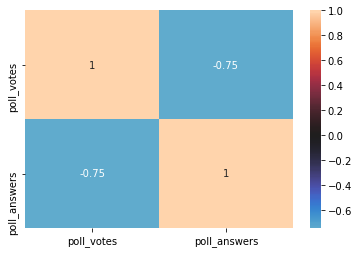

In [85]:
corr_m = df[df.poll_answers > 0].loc[:, 'poll_votes':].corr()
sns.heatmap(corr_m, center=0, annot=True)

In [86]:
df.head()

,id,date,time,text_len,attachments_num,hashtag,view,comment,like,repost,poll_votes,poll_answers
0,0,2021-06-22,18:19:33,327,1,skillbox_игры,16529,0.000000,101.279812,168.189412,0.0,0
1,0,2021-06-22,18:19:33,327,1,статья_skillbox,16529,0.000000,101.279812,168.189412,0.0,0
2,1,2021-06-22,13:30:46,658,5,skillbox_курсы,16708,85.274452,74.115359,44.850510,0.0,0
3,2,2021-06-21,18:43:52,110,1,skillbox_маркетинг,19354,110.146167,90.212813,135.085465,0.0,0
4,2,2021-06-21,18:43:52,110,1,статья_skillbox,19354,110.146167,90.212813,135.085465,0.0,0


In [87]:
# чем больше вариантов ответов, тем меньше проголосовавщих

In [88]:
count = df.groupby("hashtag").count().loc[:, "id":"id"]
count

,id
hashtag,
bkmenucourt,1
ruarts_skillbox,1
ruartsfoundation,1
skillbox,10
skillbox_clubhouse,1
...,...
статья_skillbox,74
студенты_skillbox,4
чему_научились_нейросети,1


In [89]:
count[count["id"] > 4]
# отсортируем

,id
hashtag,
skillbox,10
skillbox_анонс,20
skillbox_вдохновляет,10
skillbox_дизайн,69
skillbox_игры,5
skillbox_маркетинг,51
skillbox_программирование,23
skillbox_управление,17
в_закладки_skillbox,43


In [90]:
# 13 рубрик
rubrics = list(count[count["id"] > 4].index)
rubrics


['skillbox',
 'skillbox_анонс',
 'skillbox_вдохновляет',
 'skillbox_дизайн',
 'skillbox_игры',
 'skillbox_маркетинг',
 'skillbox_программирование',
 'skillbox_управление',
 'в_закладки_skillbox',
 'высшее_образование_skillbox',
 'лекторий_skillbox',
 'расписание_skillbox',
 'статья_skillbox']

In [91]:
import numpy as np
def av_med(df):
    cols = ["comment", "like", "repost"]
    meds = []
    if df.shape[0] != df[df["poll_votes"] == 0].shape[0]:
        meds.append(df[df["poll_votes"] != 0]["poll_votes"].median())
    for i in cols:
        meds.append(df[i].mean())
    return np.mean(meds)

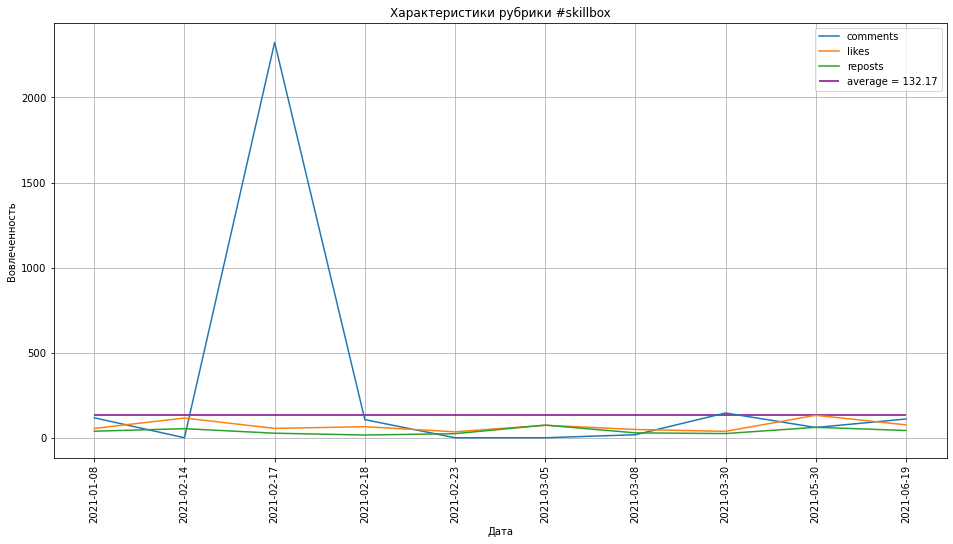

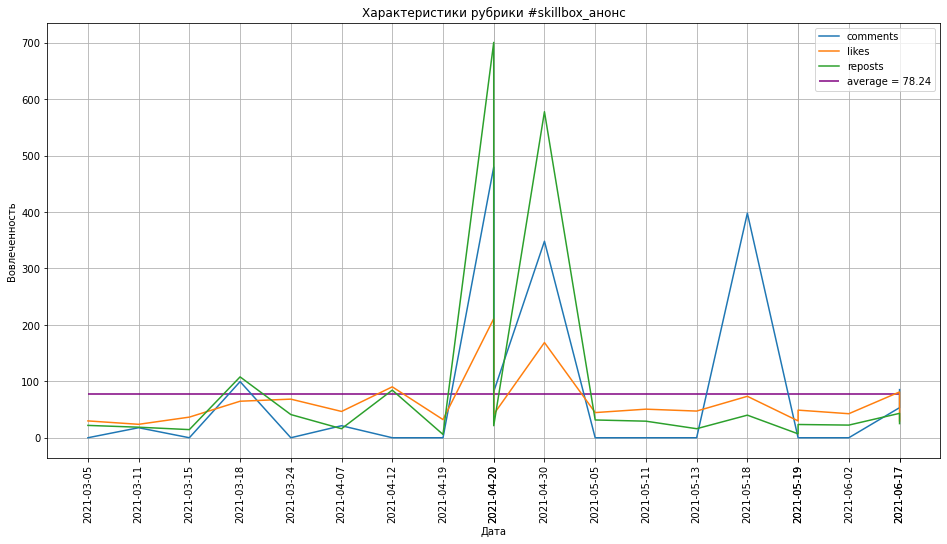

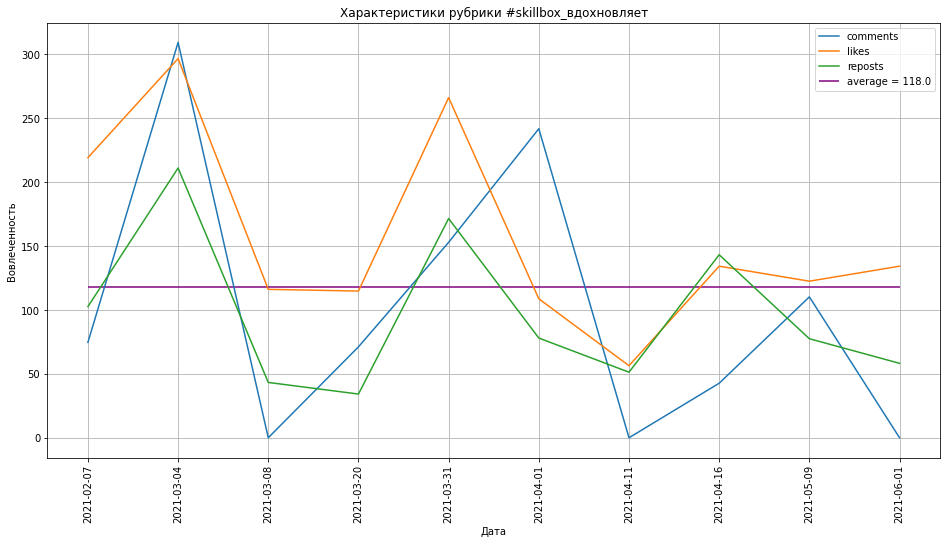

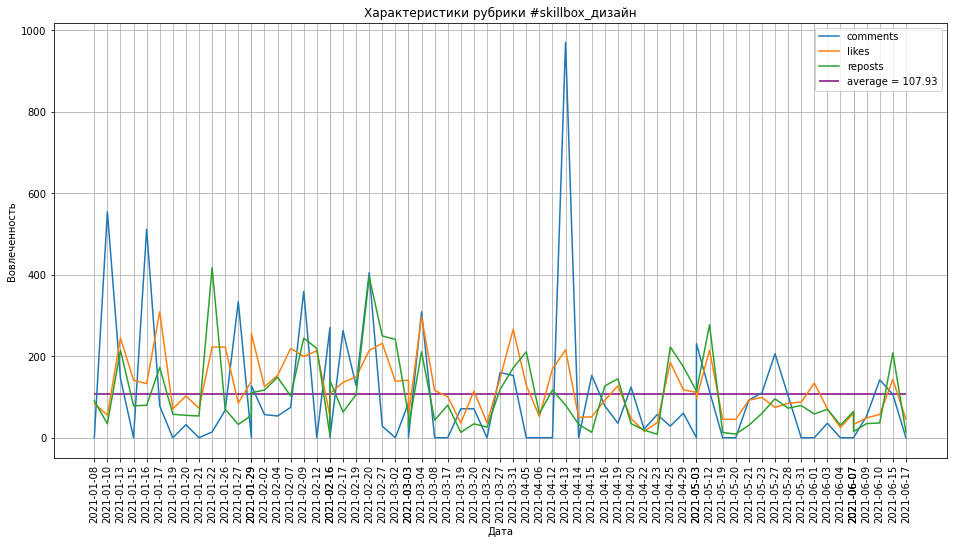

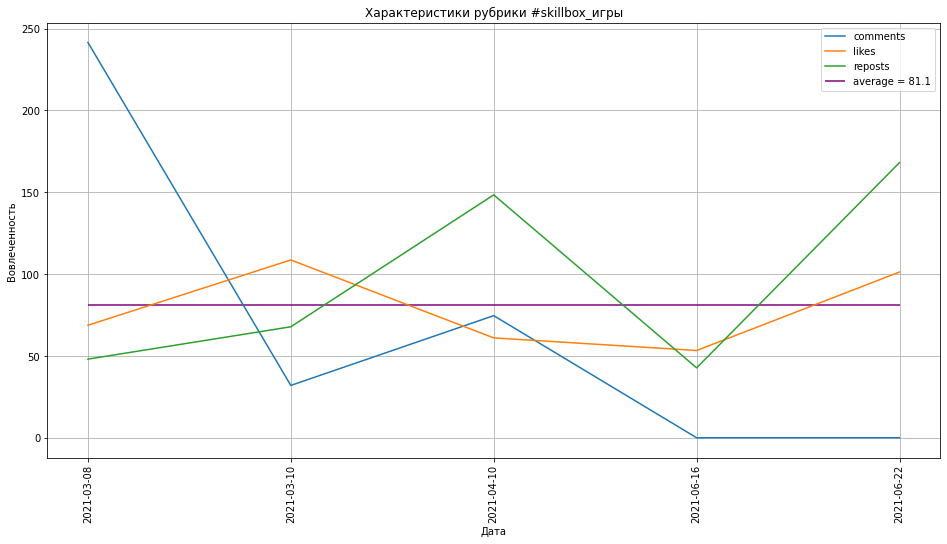

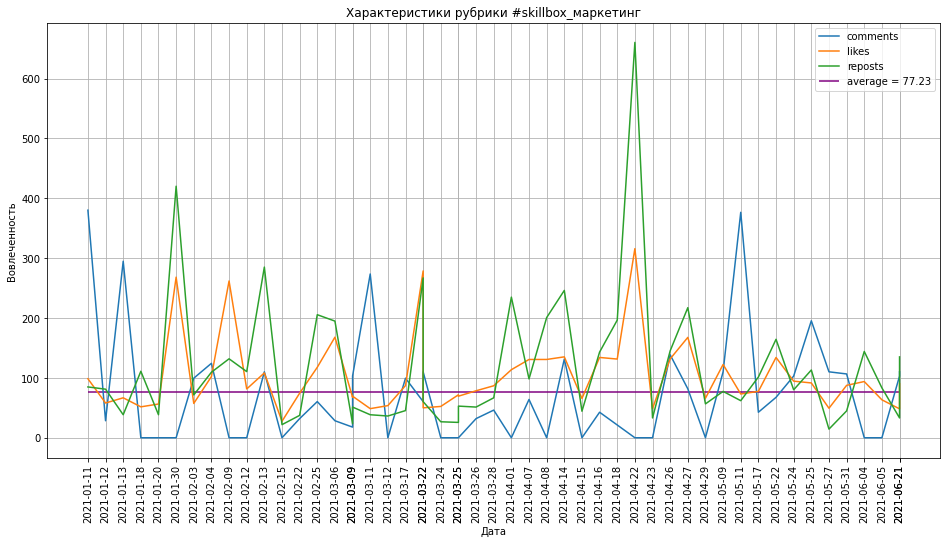

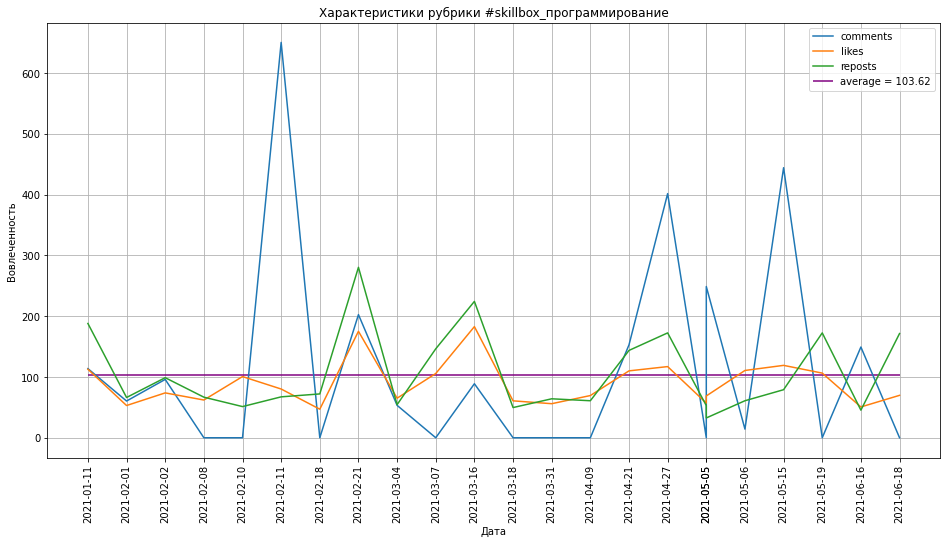

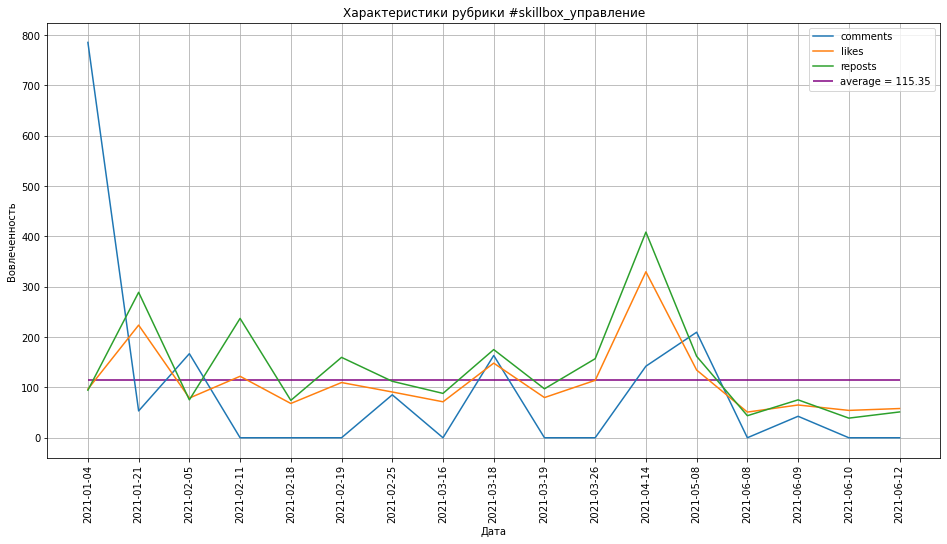

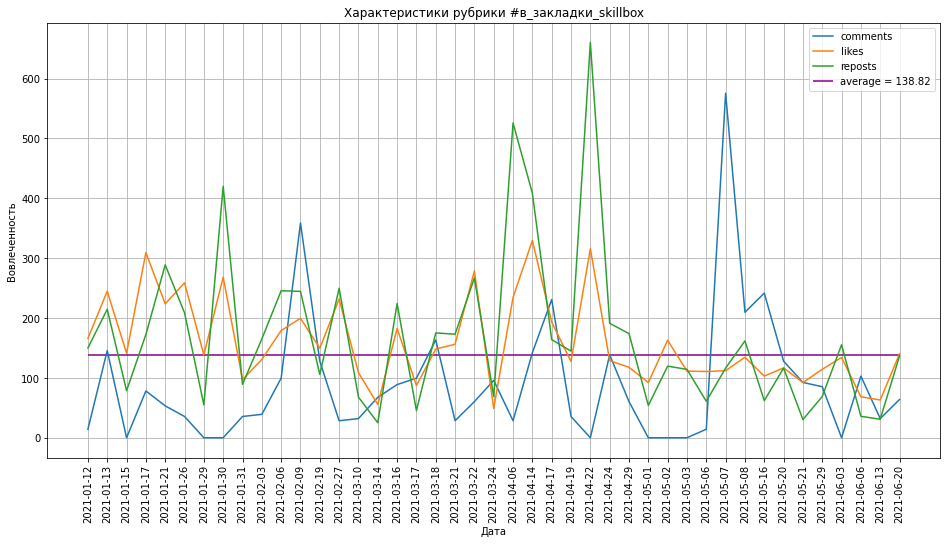

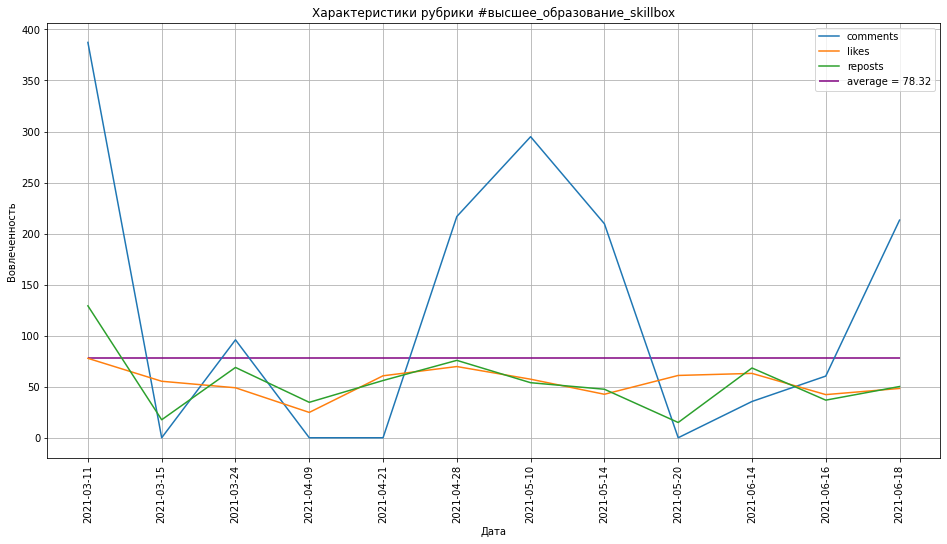

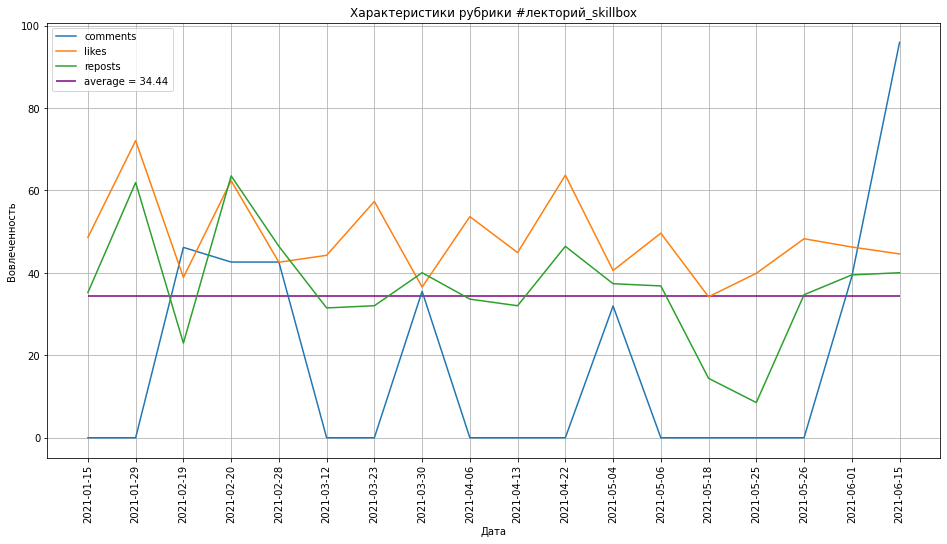

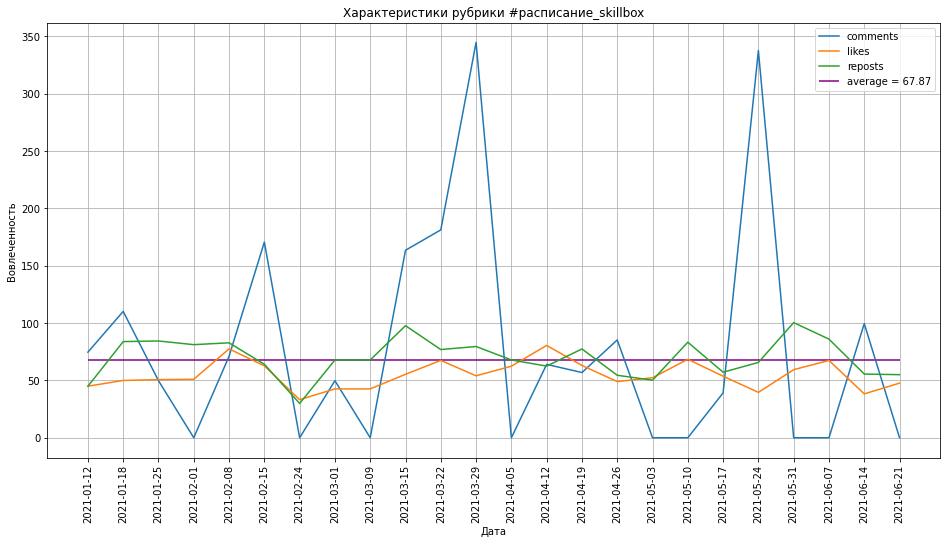

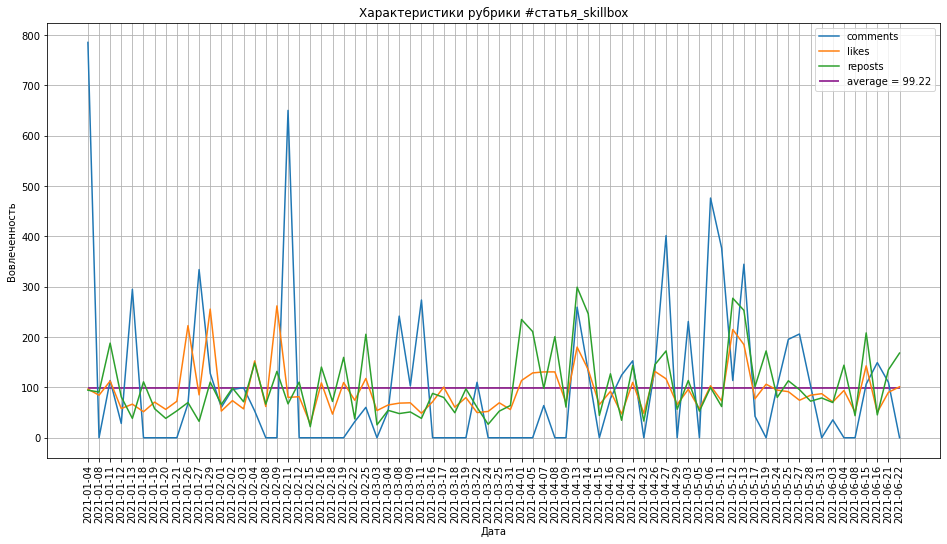

In [92]:
from matplotlib import pyplot as plt
df = df.sort_values("date")
for ind, r in enumerate(rubrics):
    current_df = df[df["hashtag"] == r]
    xticks = current_df["date"]
    am = av_med(current_df)
    fig, subplot = plt.subplots()
    fig.set_size_inches(16, 8)
    plt.plot(xticks, current_df["comment"], label = "comments")
    plt.plot(xticks, current_df["like"], label = "likes")
    plt.plot(xticks, current_df["repost"], label = "reposts")
    plt.hlines(am, list(xticks)[0], list(xticks)[-1], color = "purple", label = f"average = {round(am, 2)}")
    plt.xticks(xticks, rotation = "vertical")
    plt.xlabel("Дата")
    plt.ylabel("Вовлеченность")
    plt.legend()
    plt.grid()
    plt.title(f"Характеристики рубрики #{r}")
    plt.show()